In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Greenland = pd.read_excel(filepath, sheet_name='Greenland-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Greenland)
fp.date_time(Greenland)

,Extent,Date
0,1076123.146,1979-01-01
1,1099248.063,1979-02-01
2,1036964.901,1979-03-01
3,958927.937,1979-04-01
4,823812.694,1979-05-01
...,...,...
533,721350.515,2023-06-01
534,459033.164,2023-07-01
535,282045.909,2023-08-01
536,270397.608,2023-09-01


In [5]:
scaler = MinMaxScaler()
Greenland['Extent'] = scaler.fit_transform(Greenland['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 10
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Greenland['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((517, 12, 1), (517,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Greenland_model_LT10/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 17s 201ms/step - loss: 0.2679 - root_mean_squared_error: 0.5176 - val_loss: 0.0993 - val_root_mean_squared_error: 0.3151
Epoch 2/50
53/53 [==============================] - 10s 191ms/step - loss: 0.0902 - root_mean_squared_error: 0.3003 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1947
Epoch 3/50
53/53 [==============================] - 10s 198ms/step - loss: 0.0553 - root_mean_squared_error: 0.2352 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1878
Epoch 4/50
53/53 [==============================] - 11s 208ms/step - loss: 0.0511 - root_mean_squared_error: 0.2261 - val_loss: 0.0329 - val_root_mean_squared_error: 0.1814
Epoch 5/50
53/53 [==============================] - 2s 30ms/step - loss: 0.0494 - root_mean_squared_error: 0.2222 - val_loss: 0.0343 - val_root_mean_squared_error: 0.1852
Epoch 6/50
53/53 [==============================] - 2s 29ms/step - loss: 0.0482 - root_mean_squared_error: 0.2195 - val_loss: 0.0348 - va

53/53 [==============================] - 2s 30ms/step - loss: 0.0158 - root_mean_squared_error: 0.1257 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1435
Epoch 42/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0156 - root_mean_squared_error: 0.1250 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1474
Epoch 43/50
53/53 [==============================] - 10s 188ms/step - loss: 0.0140 - root_mean_squared_error: 0.1182 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1065
Epoch 44/50
53/53 [==============================] - 2s 30ms/step - loss: 0.0159 - root_mean_squared_error: 0.1262 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1453
Epoch 45/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0148 - root_mean_squared_error: 0.1219 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1484
Epoch 46/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0235 - val_root_mean_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

2.7069816986719766 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

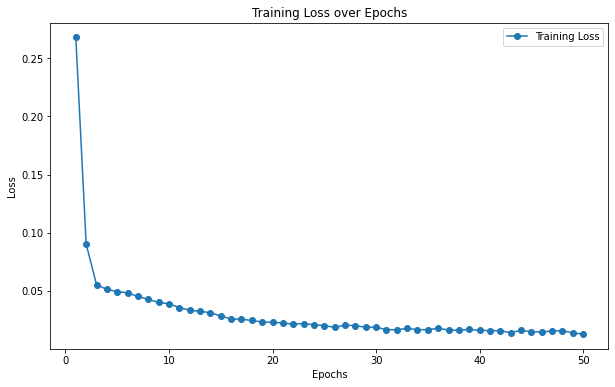

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

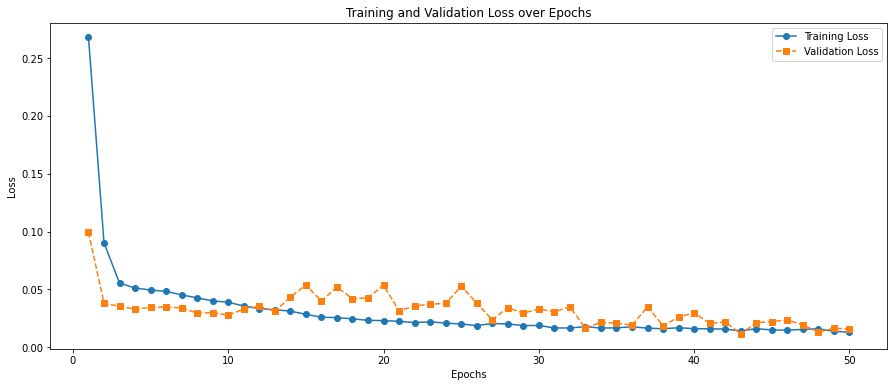

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Greenland_model_LT10/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 22ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.0881408464679107
MAE : 0.06515580360389855


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,704283.93750,641562.292
1,729634.18750,734946.437
2,725525.06250,777596.225
3,681450.93750,687087.673
4,588808.56250,622337.816
5,470628.96875,467232.074
6,387827.06250,297495.641
7,353944.53125,268909.854
8,381189.28125,408072.791
9,454419.03125,552314.148


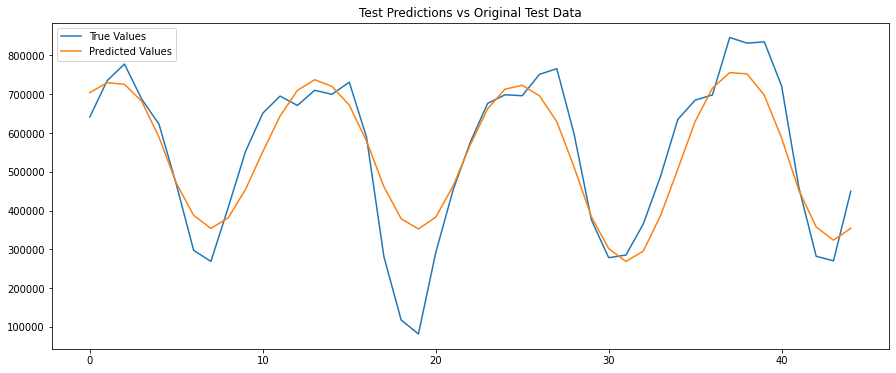

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 15ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

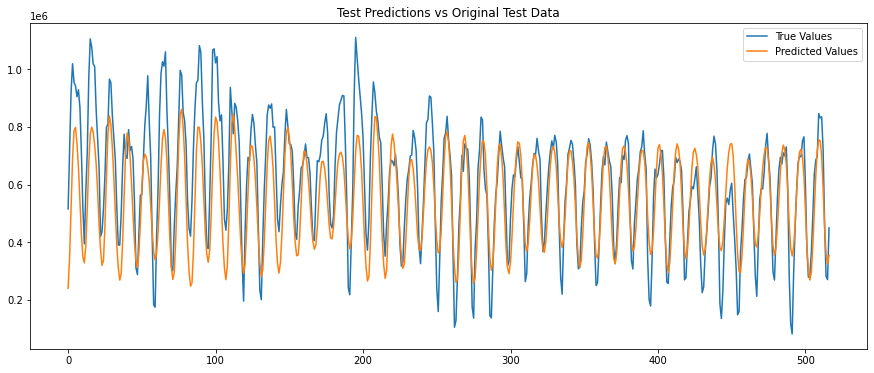

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()